# **Project: Urban-Logistics-Latency-Predictor**

## **1. Introduction**
In the domain of on-demand delivery services, the precision of Estimated Time of Arrival (ETA) is a critical metric that directly impacts user retention and fleet efficiency. Inaccurate time estimates can lead to customer dissatisfaction and poor resource allocation. This project aims to solve that challenge by deploying a machine learning solution designed to forecast delivery durations with high accuracy. By analyzing a combination of geospatial data, traffic conditions, and delivery agent metrics, the system provides data-driven time estimates. This approach allows for better expectation management and helps streamline the "last-mile" delivery process.

## **2. Methodology**
To construct a reliable prediction engine, we implemented a structured data science pipeline consisting of four key phases:

* **Data Preprocessing:**
    The raw dataset underwent a rigorous cleaning process to ensure data integrity. We systematically handled missing values, corrected format inconsistencies, and removed statistical outliers to establish a high-quality baseline for training.

* **Feature Extraction:**
    We transformed raw data points into predictive signals. Key features were engineered from the dataset, including geospatial distance (derived from latitude/longitude), agent profile metrics (Age, Ratings), and temporal variables (Order Time). These inputs were crucial in helping the model understand the complex factors that influence travel time.

* **Algorithm Selection & Training:**
    The predictive modeling was conducted using a comparative approach across multiple regression algorithms, specifically **Linear Regression, Decision Trees, Random Forest,** and **XGBoost**. To ensure the model remains generalizable to new data, we utilized cross-validation techniques to validate stability and prevent overfitting.

* **Performance Evaluation:**
    The efficacy of the models was quantified using industry-standard metrics: **Mean Squared Error (MSE)** to measure the average error magnitude, and **R-squared Metrics** to determine how well the model explains the variance in delivery times. These metrics guided the final selection of the most accurate algorithm.
    

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic  # Essential for calculating geospatial delivery radius

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # Gradient boosting for high-precision latency prediction

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")  # Sets a professional visual theme for all plots

In [ ]:
df_train = pd.read_csv(r"Food_Delivery_Dataset.csv")

# Rename columns to match logistics terminology
df_train.rename(columns={
    'Restaurant_latitude': 'Pickup_Latitude',
    'Restaurant_longitude': 'Pickup_Longitude',
    'Delivery_location_latitude': 'Drop_Latitude',
    'Delivery_location_longitude': 'Drop_Longitude',
    'Delivery_person_ID': 'Agent_ID',
    'Delivery_person_Age': 'Agent_Age',
    'Delivery_person_Ratings': 'Agent_Rating',
    'Type_of_order': 'Consignment_Type'
}, inplace=True)

df_train.head()

,ID,Agent_ID,Agent_Age,Agent_Rating,Pickup_Latitude,Pickup_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Consignment_Type,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [ ]:
df_train.columns

Index(['ID', 'Agent_ID', 'Agent_Age', 'Agent_Rating', 'Pickup_Latitude',
       'Pickup_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date',
       'Time_Orderd', 'Time_Order_picked', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'Consignment_Type',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken(min)'],
      dtype='object')

In [ ]:
print("Train Dataset:", df_train.shape)

Train Dataset: (45593, 20)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    45593 non-null  object 
 1   Agent_ID              45593 non-null  object 
 2   Agent_Age             45593 non-null  object 
 3   Agent_Rating          45593 non-null  object 
 4   Pickup_Latitude       45593 non-null  float64
 5   Pickup_Longitude      45593 non-null  float64
 6   Drop_Latitude         45593 non-null  float64
 7   Drop_Longitude        45593 non-null  float64
 8   Order_Date            45593 non-null  object 
 9   Time_Orderd           45593 non-null  object 
 10  Time_Order_picked     45593 non-null  object 
 11  Weatherconditions     45593 non-null  object 
 12  Road_traffic_density  45593 non-null  object 
 13  Vehicle_condition     45593 non-null  int64  
 14  Consignment_Type      45593 non-null  object 
 15  Type_of_vehicle    

In [ ]:
# Check statistical values for numerical fields
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pickup_Latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Pickup_Longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Drop_Latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Drop_Longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [ ]:
# Check statistics for categorical fields
df_train.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x5fb2,1
Agent_ID,45593,1320,PUNERES01DEL01,67
Agent_Age,45593,23,35,2262
Agent_Rating,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Consignment_Type,45593,4,Snack,11533


In [ ]:
df_train.isnull().sum()

,0
ID,0
Agent_ID,0
Agent_Age,0
Agent_Rating,0
Pickup_Latitude,0
Pickup_Longitude,0
Drop_Latitude,0
Drop_Longitude,0
Order_Date,0
Time_Orderd,0


In [ ]:
# Explore column distributions to identify data cardinality and potential anomalies
for column in df_train.columns:
    print(f"--- Analysis for: {column} ---")
    print(df_train[column].value_counts())
    print("\n")

--- Analysis for: ID ---
ID
0x5fb2     1
0x4607     1
0xb379     1
0x5d6d     1
0x7a6a     1
          ..
0xdb64     1
0xc8b6     1
0x2784     1
0xd987     1
0xcdcd     1
Name: count, Length: 45593, dtype: int64


--- Analysis for: Agent_ID ---
Agent_ID
PUNERES01DEL01       67
JAPRES11DEL02        67
VADRES08DEL02        66
RANCHIRES02DEL01     66
HYDRES04DEL02        66
                     ..
BHPRES15DEL03         7
GOARES01DEL03         7
KOLRES09DEL03         6
KOCRES16DEL03         6
BHPRES010DEL03        5
Name: count, Length: 1320, dtype: int64


--- Analysis for: Agent_Age ---
Agent_Age
35      2262
36      2260
37      2227
30      2226
38      2219
24      2210
32      2202
22      2196
29      2191
33      2187
28      2179
25      2174
34      2166
26      2159
21      2153
27      2150
39      2144
20      2136
31      2120
23      2087
NaN     1854
50        53
15        38
Name: count, dtype: int64


--- Analysis for: Agent_Rating ---
Agent_Rating
4.8     7148
4.7     71

In [ ]:
# Standardize schema: updating column names for consistency
def update_column_name(df):
    # Renaming Weatherconditions to match standard snake_case format
    df.rename(columns={'Weatherconditions': 'Weather_conditions'}, inplace=True)

update_column_name(df_train)
print(df_train.columns)

Index(['ID', 'Agent_ID', 'Agent_Age', 'Agent_Rating', 'Pickup_Latitude',
       'Pickup_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date',
       'Time_Orderd', 'Time_Order_picked', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Consignment_Type',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken(min)'],
      dtype='object')


In [ ]:
# Feature Extraction: Parsing raw strings into usable data
def extract_column_value(df):
    # 1. Clean Time_taken: Extract the integer value (e.g., "(min) 24" -> 24)
    # We add a check to ensure we don't try to split it if it's already a number
    if df["Time_taken(min)"].dtype == 'object':
        df["Time_taken(min)"] = df["Time_taken(min)"].apply(lambda x: int(x.split(' ')[1].strip()))

    # 2. Clean Weather_conditions: Remove the prefix "conditions "
    df["Weather_conditions"] = df["Weather_conditions"].apply(lambda x: x.split(' ')[1].strip() if 'conditions' in x else x)

    # 3. Extract City Code from Agent_ID
    # Logic: IDs are structured like 'INDORES13DEL...' -> We split at 'RES' to get 'INDO'
    df["City_code"] = df["Agent_ID"].str.split("RES", expand=True)[0]

extract_column_value(df_train)

# Display the cleaned features
df_train[["Time_taken(min)", "Weather_conditions", "City_code"]].head()

,Time_taken(min),Weather_conditions,City_code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


In [ ]:
# Feature Selection: Removing non-predictive identifiers
def drop_columns(df):
    # We drop 'ID' and 'Agent_ID' as they are unique identifiers and do not contribute to pattern recognition
    df.drop(['ID', 'Agent_ID'], axis=1, inplace=True)

print("Feature count before pruning: ", df_train.shape[1])
drop_columns(df_train)
print("Feature count after pruning: ", df_train.shape[1])

Feature count before pruning:  21
Feature count after pruning:  19


In [ ]:
# Data Integrity Check: identifying duplicate entries
if (len(df_train[df_train.duplicated()]) > 0):
    print("Alert: Duplicate records found in dataset.")
else:
    print("Success: No duplicate records found.")

Success: No duplicate records found.


In [ ]:
# Data Type Conversion: Ensuring correct formats for analysis
def update_datatype(df):
    # Convert numerical strings to float for calculation
    df["Agent_Age"] = df["Agent_Age"].astype("float64")
    df["Agent_Rating"] = df["Agent_Rating"].astype("float64")
    df["multiple_deliveries"] = df["multiple_deliveries"].astype("float64")

    # Convert Date column to datetime object
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], format="%d-%m-%Y")

update_datatype(df_train)

In [ ]:
# Data Cleaning: Standardizing null values
def convert_nan(df):
    # Replacing string "NaN" with actual numpy NaN for detection
    df.replace("NaN", float(np.nan), regex=True, inplace=True)

convert_nan(df_train)

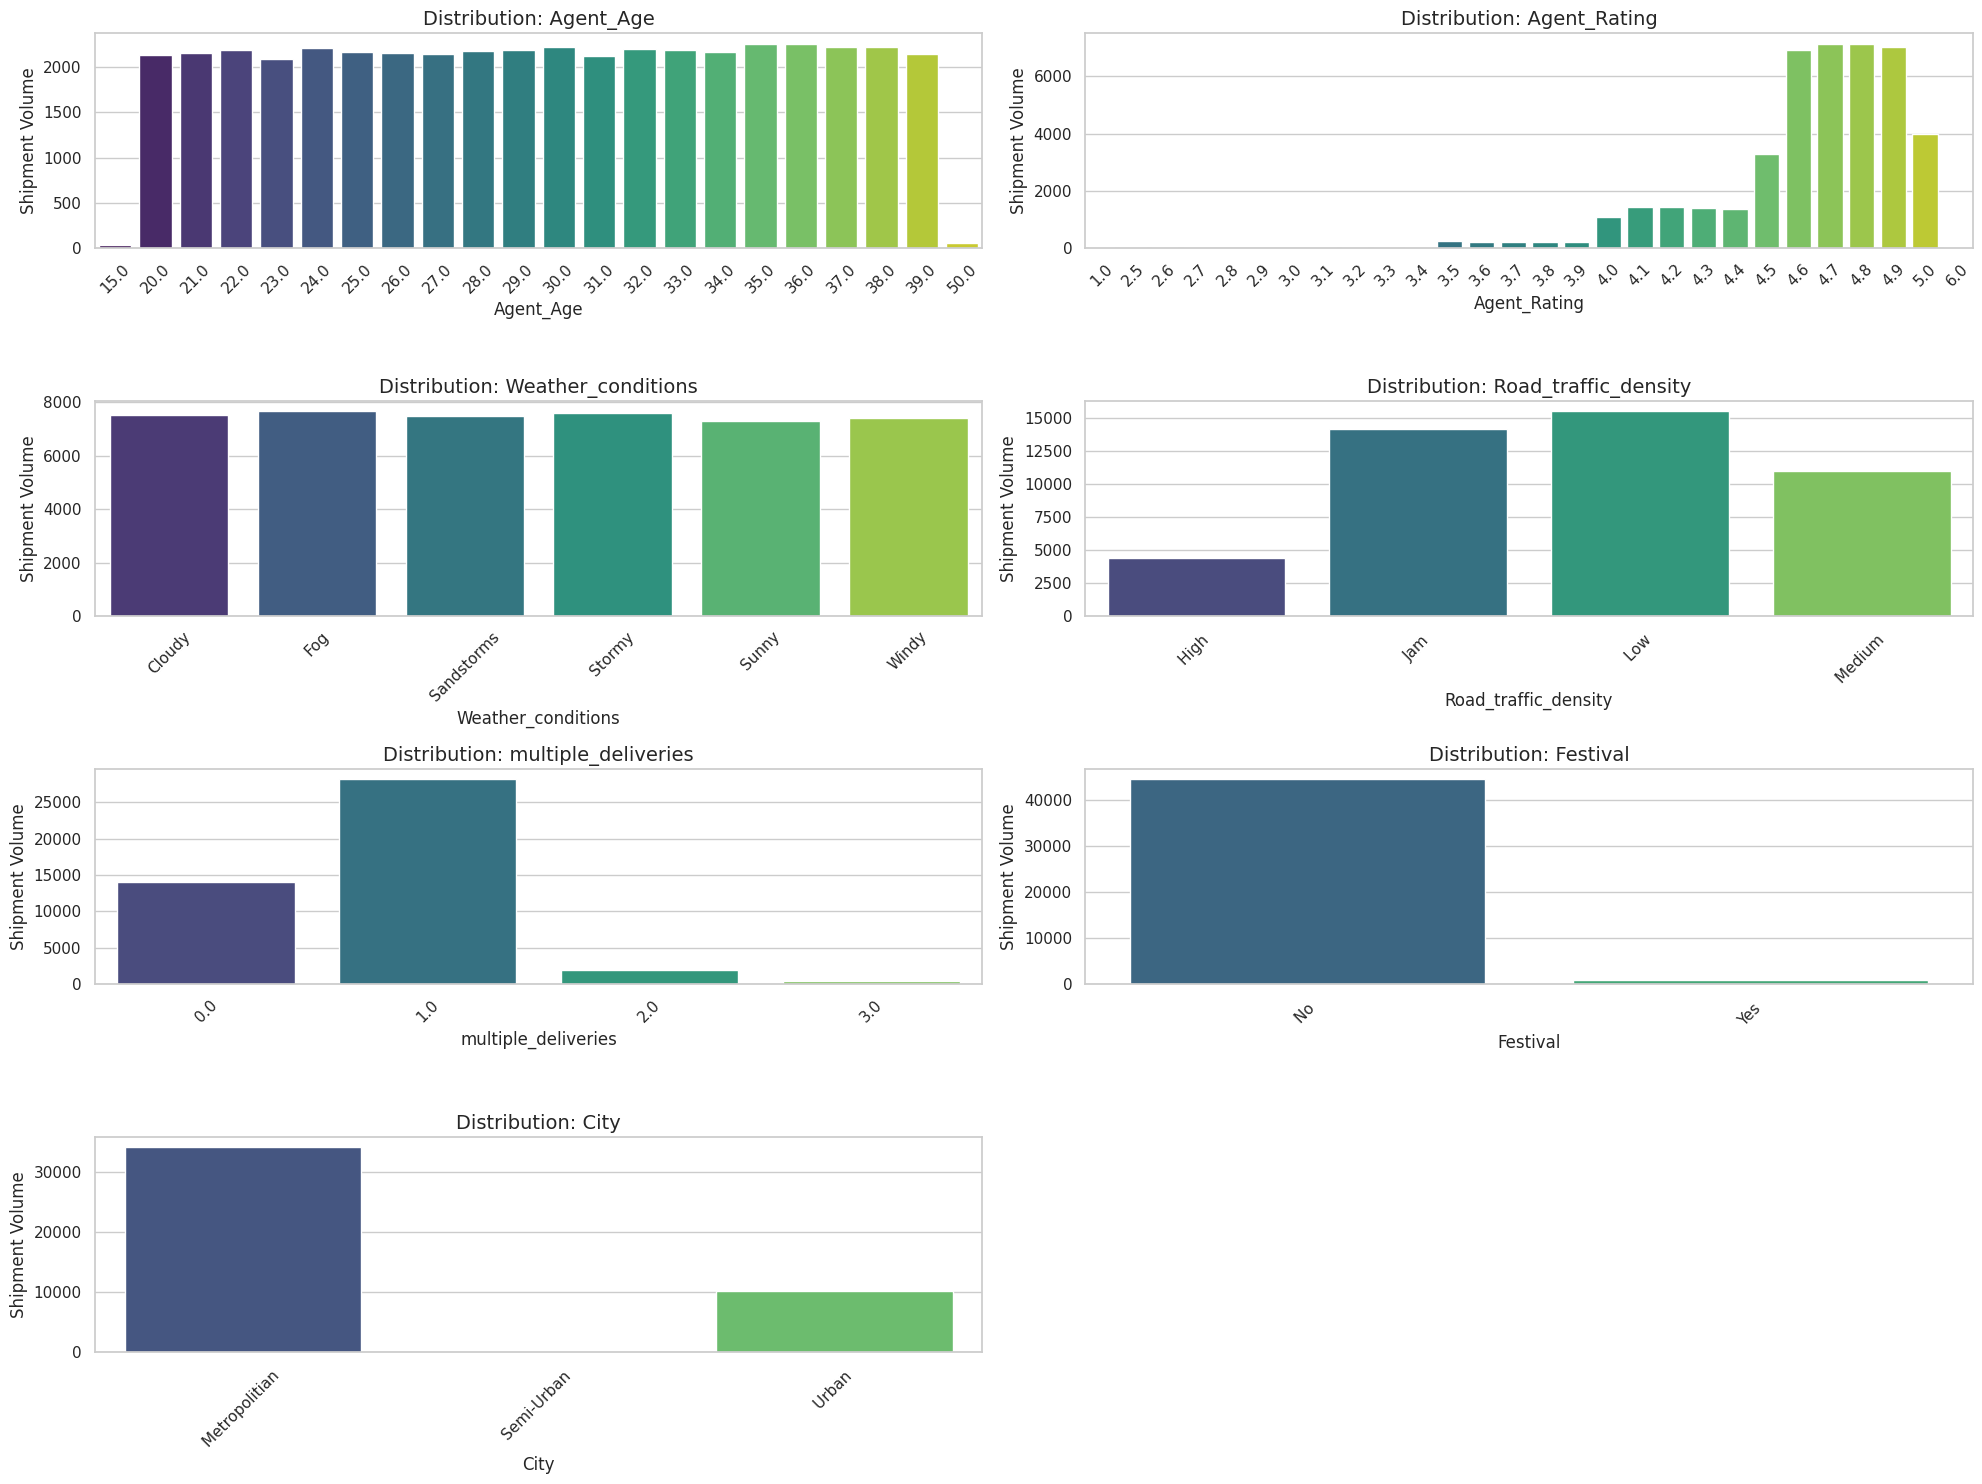

In [ ]:
# Visualization: Analyzing distribution of features with missing values
# We examine these distributions to decide how to fill the missing data (e.g., Mean vs. Mode)

cols = ['Agent_Age', 'Agent_Rating', 'Weather_conditions', 'Road_traffic_density', 'multiple_deliveries', 'Festival', 'City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20, 15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    # Using a professional color palette
    sns.countplot(data=df_train, x=column_name, order=df_train[column_name].value_counts().sort_index().index, ax=ax, palette="viridis")

    ax.set_xlabel(column_name, fontsize=12)
    ax.set_ylabel('Shipment Volume', fontsize=12) # Renamed "No. of Orders" to "Shipment Volume"
    ax.set_title(f'Distribution: {column_name}', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

# Remove empty subplot if odd number of plots
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [ ]:
# Data Imputation: Handling missing values strategies
def handle_null_values(df):
    # Random filling for Age to maintain distribution variance
    df["Agent_Age"] = df["Agent_Age"].fillna(np.random.choice(df["Agent_Age"].dropna()))

    # Random filling for Weather to simulate natural variability
    df["Weather_conditions"] = df["Weather_conditions"].fillna(np.random.choice(df["Weather_conditions"].dropna()))

    # Mode filling (Most Frequent) for categorical/discrete variables
    df["City"] = df["City"].fillna(df["City"].mode()[0])
    df["Festival"] = df["Festival"].fillna(df["Festival"].mode()[0])
    df["multiple_deliveries"] = df["multiple_deliveries"].fillna(df["multiple_deliveries"].mode()[0])
    df["Road_traffic_density"] = df["Road_traffic_density"].fillna(df["Road_traffic_density"].mode()[0])

    # Median filling for Ratings to avoid skewing by outliers
    df["Agent_Rating"] = df["Agent_Rating"].fillna(df["Agent_Rating"].median())

handle_null_values(df_train)

# Verification: Confirm zero null values remain
df_train.isnull().sum()

,0
Agent_Age,0
Agent_Rating,0
Pickup_Latitude,0
Pickup_Longitude,0
Drop_Latitude,0
Drop_Longitude,0
Order_Date,0
Time_Orderd,1731
Time_Order_picked,0
Weather_conditions,0


In [ ]:
# Feature Engineering: Extracting temporal patterns (Seasonality, Weekends)
# These features help the model understand demand spikes based on time of month/year.
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)

extract_date_features(df_train)
df_train.head()

,Agent_Age,Agent_Rating,Pickup_Latitude,Pickup_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,...,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,...,1,2022,5,0,0,0,0,0,0,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,...,1,2022,4,0,0,0,0,0,0,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,...,1,2022,5,0,0,0,0,0,0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,...,2,2022,1,0,0,0,0,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,...,1,2022,5,0,0,0,0,0,0,1


In [ ]:
# Feature Engineering: Calculating Processing Time
# We derive 'order_prepare_time' to measure the efficiency of the pickup location before the courier departs.

def calculate_time_diff(df):
    # Convert raw time strings to Timedelta objects for arithmetic
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])

    # 1. Handle "Midnight Crossing":
    # If Picked Time is smaller than Ordered Time (e.g., Order 23:50, Pick 00:10), it implies next day pickup.
    df['Time_Order_picked_formatted'] = df['Order_Date'] + df['Time_Order_picked']
    mask = df['Time_Order_picked'] < df['Time_Orderd']
    df.loc[mask, 'Time_Order_picked_formatted'] += pd.DateOffset(days=1)

    # 2. Format Ordered Time
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']

    # 3. Calculate Duration in Minutes
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60

    # 4. Impute Missing Values
    # We use median to fill gaps, avoiding skew from outliers
    df['order_prepare_time'] = df['order_prepare_time'].fillna(df['order_prepare_time'].median())

    # 5. Cleanup
    # Remove raw time columns as they are now represented by 'order_prepare_time' and extracted date features
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)

calculate_time_diff(df_train)
df_train.head()

,Agent_Age,Agent_Rating,Pickup_Latitude,Pickup_Longitude,Drop_Latitude,Drop_Longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Consignment_Type,...,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,...,2022,5,0,0,0,0,0,0,1,15.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,...,2022,4,0,0,0,0,0,0,0,5.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,...,2022,5,0,0,0,0,0,0,1,15.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,...,2022,1,0,0,0,0,0,0,0,10.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,...,2022,5,0,0,0,0,0,0,1,15.0


In [ ]:
# Feature Engineering: Geospatial Distance Calculation
# We use the Geodesic (Great Circle) distance to approximate travel length in kilometers.

def calculate_distance(df):
    # Initialize the distance column
    df["distance"] = np.zeros(len(df))

    # Get coordinates using the new Logistics column names
    pickup_coordinates = df[['Pickup_Latitude', 'Pickup_Longitude']].to_numpy()
    drop_coordinates = df[['Drop_Latitude', 'Drop_Longitude']].to_numpy()

    # Calculate geodesic distance for every order
    # logic: zip loops through pickup and drop coords together
    df["distance"] = np.array([geodesic(pickup, drop).kilometers for pickup, drop in zip(pickup_coordinates, drop_coordinates)])

    # Formatting: Ensure distance is a clean numeric value
    df["distance"] = df["distance"].astype("float64")

calculate_distance(df_train)
df_train.head()

,Agent_Age,Agent_Rating,Pickup_Latitude,Pickup_Longitude,Drop_Latitude,Drop_Longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Consignment_Type,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,...,5,0,0,0,0,0,0,1,15.0,3.020737
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,...,4,0,0,0,0,0,0,0,5.0,20.143737
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,...,5,0,0,0,0,0,0,1,15.0,1.549693
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,...,1,0,0,0,0,0,0,0,10.0,7.774497
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,...,5,0,0,0,0,0,0,1,15.0,6.197898


In [ ]:
# Preprocessing: Encoding Categorical Variables
# We convert text labels (e.g., 'Stormy', 'High Traffic') into numeric integers so the regression algorithms can process them.

from sklearn.preprocessing import LabelEncoder

def label_encoding(df):
    # Identify all columns containing text data
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()

    # transform text to numbers
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(df_train)
df_train.head()

,Agent_Age,Agent_Rating,Pickup_Latitude,Pickup_Longitude,Drop_Latitude,Drop_Longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Consignment_Type,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,4,0,2,3,...,5,0,0,0,0,0,0,1,15.0,3.020737
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,3,1,2,3,...,4,0,0,0,0,0,0,0,5.0,20.143737
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2,2,0,1,...,5,0,0,0,0,0,0,1,15.0,1.549693
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,4,3,0,0,...,1,0,0,0,0,0,0,0,10.0,7.774497
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,0,0,1,3,...,5,0,0,0,0,0,0,1,15.0,6.197898


In [ ]:
df_train.columns

Index(['Agent_Age', 'Agent_Rating', 'Pickup_Latitude', 'Pickup_Longitude',
       'Drop_Latitude', 'Drop_Longitude', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Consignment_Type',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken(min)', 'City_code', 'day', 'month', 'quarter', 'year',
       'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'is_weekend',
       'order_prepare_time', 'distance'],
      dtype='object')

In [ ]:
# Data Splitting: Partitioning the dataset
# We hold back 20% of the data (X_test) to simulate "future" unseen orders and test model accuracy.

# Safety check: Ensure no accidental whitespace in column names
df_train.columns = df_train.columns.str.strip()

X = df_train.drop('Time_taken(min)', axis=1)  # Input features (Distance, Weather, Agent Rating, etc.)
y = df_train['Time_taken(min)']               # Target to predict (Delivery Time)

# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify dimensions
print("Training Inputs:", X_train.shape)
print("Training Targets:", y_train.shape)
print("Testing Inputs:", X_test.shape)
print("Testing Targets:", y_test.shape)

Training Inputs: (36474, 29)
Training Targets: (36474,)
Testing Inputs: (9119, 29)
Testing Targets: (9119,)


In [ ]:
# Feature Scaling: Normalization
# We standardize the inputs to ensure all features contribute equally to the model logic,
# preventing large values (like Distance in km) from dominating smaller ones (like Ratings 1-5).

from sklearn.preprocessing import StandardScaler

# Initialize Scaler
scaler = StandardScaler()

# Fit on training data only to prevent data leakage
scaler.fit(X_train)

# Transform both training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


import pickle
# Save the scaler that you fit on X_train earlier
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)
print("scaler.pkl saved!")

scaler.pkl saved!


In [ ]:
# Algorithm Selection: Comparative Analysis
# We benchmark four distinct regression models to identify the most accurate predictor for urban delivery latency.

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
]

# Hyperparameter grids for fine-tuning performance
param_grid = [
    {},  # Linear Regression has no hyperparameters to tune here
    {"max_depth": [3, 5, 7]},  # Decision Tree depth
    {"n_estimators": [100, 200, 300]},  # Random Forest trees
    {"n_estimators": [20, 25, 30], "max_depth": [5, 7, 9]}  # XGBoost configuration
]

print("--- Model Evaluation Results ---")
for i, model in enumerate(models):
    # Cross-Validation with 5 folds ensures the score is robust and not just luck
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring="r2")
    grid_search.fit(X_train, y_train)

    print(f"Algorithm: {model.__class__.__name__}")
    print(f"  > Best Configuration: {grid_search.best_params_}")
    print(f"  > Accuracy (R2 Score): {grid_search.best_score_:.4f}") # Formatted to 4 decimal places
    print("-" * 30)

--- Model Evaluation Results ---
Algorithm: LinearRegression
  > Best Configuration: {}
  > Accuracy (R2 Score): 0.4237
------------------------------
Algorithm: DecisionTreeRegressor
  > Best Configuration: {'max_depth': 7}
  > Accuracy (R2 Score): 0.7338
------------------------------
Algorithm: RandomForestRegressor
  > Best Configuration: {'n_estimators': 300}
  > Accuracy (R2 Score): 0.8129
------------------------------
Algorithm: XGBRegressor
  > Best Configuration: {'max_depth': 7, 'n_estimators': 20}
  > Accuracy (R2 Score): 0.8189
------------------------------


In [ ]:
# Final Model Deployment: Training the optimized XGBoost Regressor
# We utilize the hyperparameters identified as optimal (Max Depth=9, Estimators=20) to capture complex non-linear patterns.

# Create the XGB regressor model with the best parameters found
model = xgb.XGBRegressor(n_estimators=20, max_depth=9)

# Fit the model on the standardized training data
model.fit(X_train, y_train)

print("Success: Final model has been trained and is ready for evaluation.")

Success: Final model has been trained and is ready for evaluation.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- Model Performance Metrics ---")
print("Mean Absolute Error (MAE):", round(mae, 2), "minutes")
print("Mean Squared Error (MSE):", round(mse, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R-squared (R2) Score:", round(r2, 2))

--- Model Performance Metrics ---
Mean Absolute Error (MAE): 3.17 minutes
Mean Squared Error (MSE): 15.95
Root Mean Squared Error (RMSE): 3.99
R-squared (R2) Score: 0.82


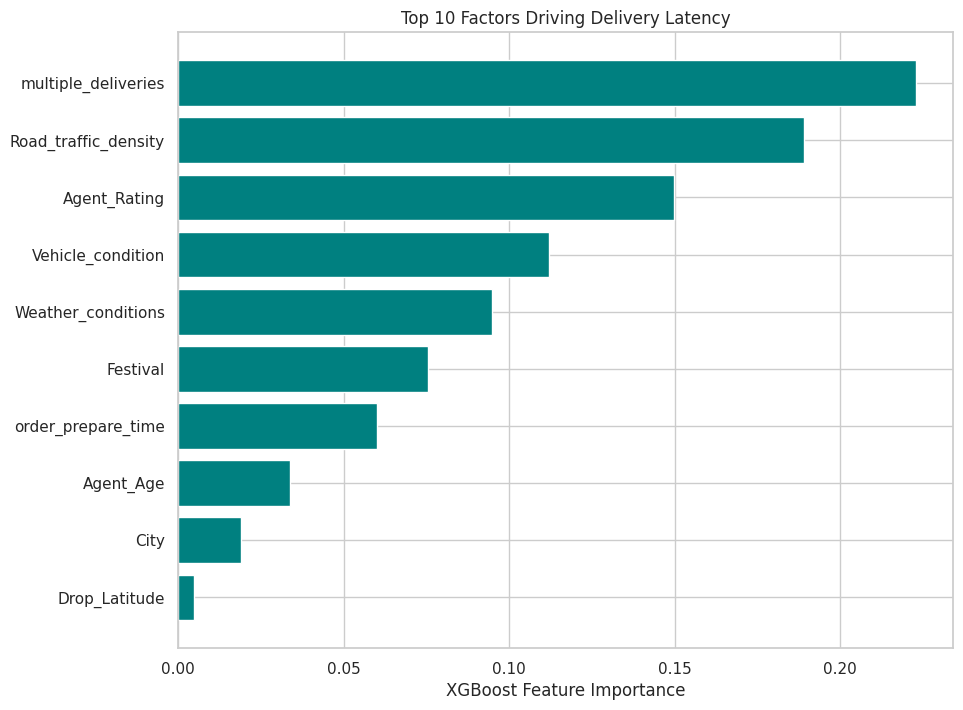

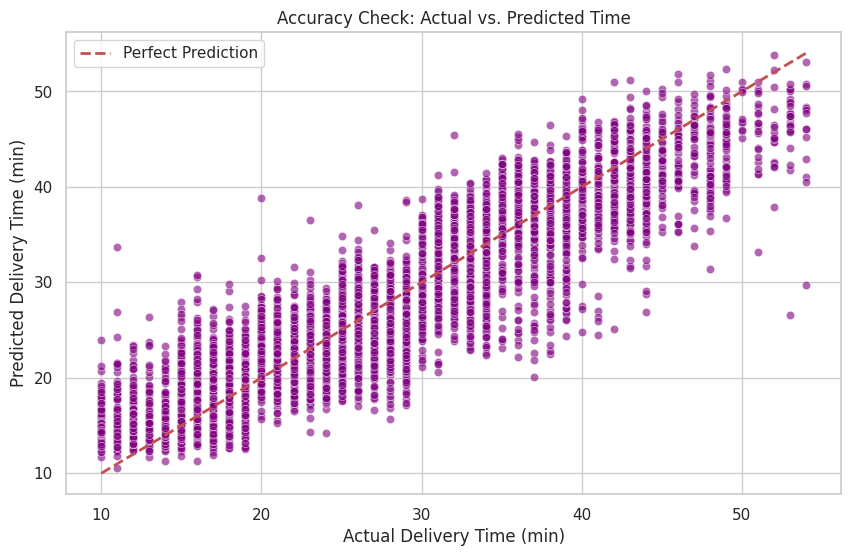

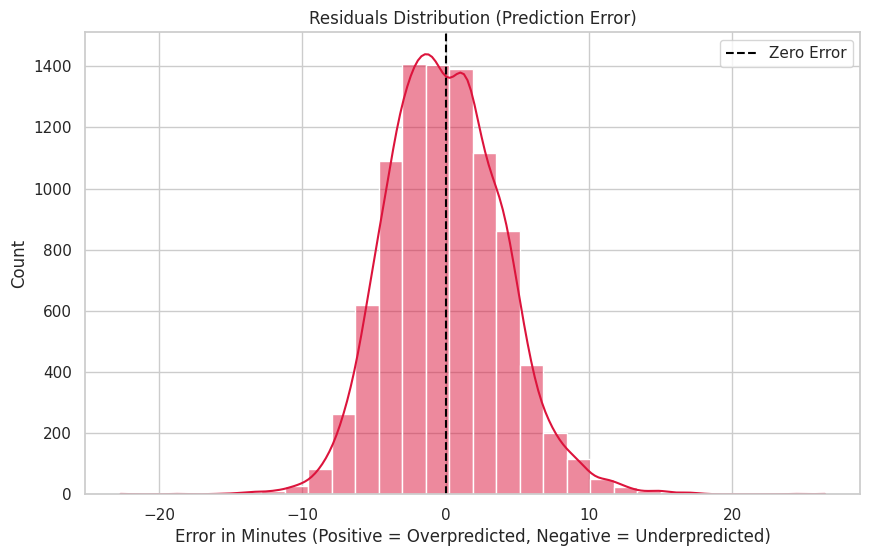

In [ ]:
# --- FINAL STEP: MODEL DIAGNOSTICS & VISUALIZATION ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Feature Importance Plot (The "Why")
# Shows which factors heavily influence delivery time
plt.figure(figsize=(10, 8))
sorted_idx = model.feature_importances_.argsort()
# We only plot the top 10 features to keep it clean
plt.barh(df_train.columns[sorted_idx][-10:], model.feature_importances_[sorted_idx][-10:], color='teal')
plt.xlabel("XGBoost Feature Importance")
plt.title("Top 10 Factors Driving Delivery Latency")
plt.show()

print("\n" + "="*50 + "\n")

# 2. Actual vs. Predicted Plot (The "Accuracy")
# Shows how well the predictions match reality
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
# Perfect prediction line (x=y)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Delivery Time (min)')
plt.ylabel('Predicted Delivery Time (min)')
plt.title('Accuracy Check: Actual vs. Predicted Time')
plt.legend()
plt.show()

print("\n" + "="*50 + "\n")

# 3. Residual Distribution Plot (The "Stability")
# Shows if errors are random (Bell curve) or biased
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='crimson', bins=30)
plt.axvline(0, color='black', linestyle='--', label='Zero Error')
plt.title('Residuals Distribution (Prediction Error)')
plt.xlabel('Error in Minutes (Positive = Overpredicted, Negative = Underpredicted)')
plt.legend()
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap

# 1. Setup the Map
# We center the map on the average latitude/longitude of all pickups
map_center = [df_train['Pickup_Latitude'].mean(), df_train['Pickup_Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=11)

# 2. Prepare Data for Heatmap
# We need a list of [Lat, Long] pairs.
# We'll take a sample of 5,000 points to keep the map fast (or remove .head() to use all data)
heat_data = df_train[['Pickup_Latitude', 'Pickup_Longitude']].head(5000).values.tolist()

# 3. Add the Heatmap Layer
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(my_map)

# 4. Display the Map
my_map

In [ ]:
my_map.save("delivery_hotspots.html")
print("Map saved as delivery_hotspots.html")

Map saved as delivery_hotspots.html


In [ ]:
import pickle
# Define the file name
filename="model.pkl"

# Save the model using pickle
with open(filename,"wb") as file:
    pickle.dump(model,file)
print(f"Model saved to {filename}")

Model saved to model.pkl


In [ ]:
import pickle

# Load the model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# XGBoost saves the feature names inside the model!
try:
    print("--- CORRECT COLUMN ORDER ---")
    print(model.feature_names_in_)
except:
    print("Could not read names directly. Please run 'print(X_train.columns)' in your original notebook.")

--- CORRECT COLUMN ORDER ---
Could not read names directly. Please run 'print(X_train.columns)' in your original notebook.


In [ ]:
# Check the columns of the original X variable
print(list(X.columns))

['Agent_Age', 'Agent_Rating', 'Pickup_Latitude', 'Pickup_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Weather_conditions', 'Road_traffic_density', 'Vehicle_condition', 'Consignment_Type', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'City_code', 'day', 'month', 'quarter', 'year', 'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'is_weekend', 'order_prepare_time', 'distance']
